#    Valuing Passes Project

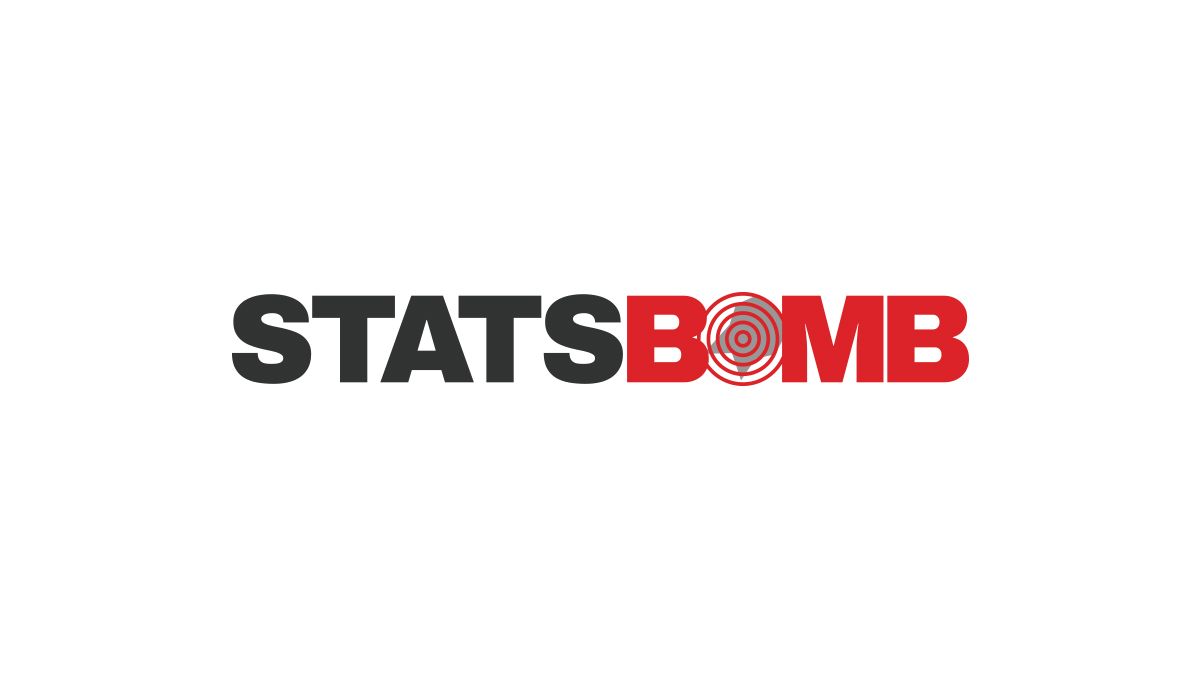

In [ ]:
import pandas as pd
from pandas import json_normalize
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
import squarify
from functools import reduce
from mplsoccer import Pitch, FontManager
from mplsoccer.statsbomb import read_event, EVENT_SLUG
from matplotlib import rcParams
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from mplsoccer import VerticalPitch, Pitch
from mplsoccer.cm import create_transparent_cmap
from mplsoccer.scatterutils import arrowhead_marker
from mplsoccer.statsbomb import read_event, EVENT_SLUG
from mplsoccer.utils import FontManager

**Load competitions json file**

In [ ]:
competitions = requests.get('https://raw.githubusercontent.com/statsbomb/open-data/master/data/competitions.json')
competitions = competitions.json()

**View different competitions**

In [ ]:
for competition in competitions:
    print(competition['competition_name'],competition['season_name'],competition['competition_id'],competition['season_id'])

# Load UEFA EURO 2020 Data

In [ ]:
euro_matches = requests.get('https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/'+str(55)+'/'+str(43)+'.json')
euro_matches = euro_matches.json()
euro_matches_df = json_normalize(euro_matches, sep = "_")

In [ ]:
print(euro_matches_df.shape)
euro_matches_df.head()

In [ ]:
euro_events = pd.DataFrame()
for i in tqdm(euro_matches_df['match_id']):
    events = requests.get('https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/'+str(i)+'.json')
    events = events.json()
    events = json_normalize(events, sep = "_")
    events['match_id'] = i
    euro_events = euro_events.append(events)

In [ ]:
pd.set_option("display.max.columns",None)

In [ ]:
euro_events.head()

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
euro_events[['x', 'y']] = euro_events['location'].progress_apply(pd.Series)
euro_events[['x_end', 'y_end']] = euro_events['pass_end_location'].progress_apply(pd.Series)
euro_events[['x_cend', 'y_cend']] = euro_events['carry_end_location'].progress_apply(pd.Series)
euro_events['pass_outcome_name'] = euro_events['pass_outcome_name'].progress_apply(lambda x: 'complete' if(pd.isnull(x)) else x)

In [ ]:
euro_events['x_end'] = [x if pd.isnull(y) else y for x,y in zip(euro_events['x_cend'],euro_events['x_end'])]
euro_events['y_end'] = [x if pd.isnull(y) else y for x,y in zip(euro_events['y_cend'],euro_events['y_end'])]
euro_events[euro_events['type_name'] == 'Pass'].head()

In [ ]:
euro_events = euro_events.drop(['x_cend', 'y_cend'], axis=1)

In [ ]:
freeze_360 = pd.DataFrame()
for i in tqdm(euro_matches_df['match_id']):
    three_sixty = requests.get('https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/'+str(i)+'.json')
    three_sixty = three_sixty.json()
    three_sixty = json_normalize(three_sixty, sep = "_")
    freeze_360 = freeze_360.append(three_sixty)

**Selecting events**

In [ ]:
actions = euro_events[euro_events['type_name'].isin(['Pass','Ball Receipt*', 'Dispossessed', 'Dribbled Past', 'Dribble',
       'Ball Recovery', 'Interception', 'Shot', 'Goal Keeper', 'Block',
       'Clearance', 'Miscontrol', 'Foul Committed', 'Foul Won',
       'Shield', 'Offside', 'Own Goal Against',
       'Own Goal For','Error','Carry','Duel'])]

In [ ]:
actions.shape

**Include end location for events doesn't have end location**

In [ ]:
%%capture --no-display
for i in range(len(actions)):
    if(pd.isnull(actions['x_end'].iloc[i])):
        actions.iloc[i,actions.columns.get_loc('x_end')] = actions['x'].iloc[i]
        actions.iloc[i,actions.columns.get_loc('y_end')] = actions['y'].iloc[i]

**Include distance and angle to goal**

In [ ]:
%%capture --no-display
diff_x = 120 - actions['x']
diff_y = abs(40 - actions['y'])
diff_x_end = 120 - actions['x_end']
diff_y_end = abs(40 - actions['y_end'])
actions['distance_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
actions['distance_to_goal_end'] = np.sqrt(diff_x_end ** 2 + diff_y_end ** 2)
actions['angle_to_goal'] = np.divide(diff_x, diff_y, out=np.zeros_like(diff_x), where=(diff_y != 0))
actions['angle_to_goal_end'] = np.divide(diff_x_end, diff_y_end, out=np.zeros_like(diff_x_end), where=(diff_y_end != 0))

**Include "if the event in the opponent penalty box" feature**

In [ ]:
%%capture --no-display
actions['start_is_penalty_box'] = ((actions['x'] > 102) & 
                                            (actions['y'] > (18)) & 
                                            (actions['y'] < (62)))

actions['end_is_penalty_box'] = ((actions['x_end'] > 102) & 
                                            (actions['y_end'] > (18)) & 
                                            (actions['y_end'] < (62)))

**Include every event as a feature**

In [ ]:
%%capture --no-display
dum_actions = pd.get_dummies(actions['type_name']).progress_apply(lambda x: x)

In [ ]:
%%capture --no-display
for i in ['Ball Recovery', 'Block', 'Carry', 'Clearance', 'Dispossessed',
       'Dribble', 'Dribbled Past', 'Duel', 'Error', 'Foul Committed',
       'Foul Won', 'Goal Keeper', 'Interception', 'Miscontrol', 'Offside',
       'Own Goal Against', 'Own Goal For', 'Pass','Ball Receipt*', 'Shield', 'Shot']:
    actions[i] = pd.Series(dum_actions[i], index=actions.index)

**Include the outcome of actions feature**

In [ ]:
%%capture --no-display
actions['result'] = ((actions['pass_outcome_name'] == 'complete') | 
                     (actions['dribble_outcome_name'] == 'Complete') | 
                     (actions['shot_outcome_name'] == 'Goal')|
                     ((actions['interception_outcome_name'] == 'Won')|
                      (actions['interception_outcome_name'] == 'Success In Play')|
                      (actions['interception_outcome_name'] == 'Success Out'))&
                     ((actions['duel_outcome_name'] == 'Won')|
                      (actions['duel_outcome_name'] == 'Success In Play')|
                      (actions['duel_outcome_name'] == 'Success Out')))

**Include the specific second of every event**

In [ ]:
%%capture --no-display
actions['time_played'] = (actions['minute']*60)+(actions['second'])

**Produce lablels**

In [ ]:
%%capture --no-display
actions['is_home_team'] = 0
is_home_team = 0
for i in range(len(actions)):
    if(actions['index'].iloc[i] == 5):
        is_home_team = actions['team_id'].iloc[i]
    if(actions['team_id'].iloc[i] == is_home_team):
        actions.iloc[i,actions.columns.get_loc('is_home_team')] = 1

In [ ]:
%%capture --no-display
actions['positive_label'] = 0
actions['negative_label'] = 0

for i in tqdm(range(len(actions))):
    
    team = actions.iloc[i]['is_home_team']
        
    for j in range(11):
        if(actions.iloc[i+j]['index'] == 5)&(j!=0):
            break
                
        if((actions.iloc[i+j]['shot_outcome_name'] == 'Goal')|(actions.iloc[i+j]['Own Goal For'] == 1))&(actions.iloc[i+j]['is_home_team']==team):
            actions.iloc[i,actions.columns.get_loc('positive_label')] = 1
        elif((actions.iloc[i+j]['shot_outcome_name'] == 'Goal')|(actions.iloc[i+j]['Own Goal For'] == 1))&(actions.iloc[i+j]['is_home_team']!=team):
            actions.iloc[i,actions.columns.get_loc('negative_label')] = 1
                
        if(i+j == len(actions)-1):
            break

**Filter dataset for only completed passes and receptance**

In [ ]:
passes = actions[(actions['Ball Receipt*'] == 1)|(actions['Pass'] == 1)]

In [ ]:
passes = passes[(passes['Ball Receipt*'] == 1)|(passes['pass_outcome_name'] == 'complete')]

In [ ]:
passes.shape

**Include 360 data features**

In [ ]:
passes = pd.merge(passes,freeze_360,left_on='id',right_on='event_uuid').progress_apply(lambda x: x)

In [ ]:
final_passes = pd.DataFrame()
for i in tqdm(range(len(passes))):
    if(i!=0):
        if(passes.type_name.iloc[i] == 'Ball Receipt*')&(passes.type_name.iloc[i-1] == 'Pass'):
            final_passes = final_passes.append(passes[i-1:i+1])
    

In [ ]:
final_passes.shape

In [ ]:
passes = final_passes.copy()

In [ ]:
def extract_frame(frame):
    
    frame[['x', 'y']] = frame['location'].apply(pd.Series)
        
    teammates = frame[frame.teammate==True]
    opponents = frame[frame.teammate==False]
    
    return(teammates,opponents)

In [ ]:
for i in range(5):
    passes['teammate_x'+str(i+1)] = 0
    passes['teammate_y'+str(i+1)] = 0
    passes['opponent_x'+str(i+1)] = 0
    passes['opponent_y'+str(i+1)] = 0

In [ ]:
def dist_angle_to_goal(df):
    diff_x = 120 - df['x']
    diff_y = abs(40 - df['y'])
    df['dist_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
    df['angle_to_goal'] = np.divide(diff_x, diff_y, out=np.zeros_like(diff_x), where=(diff_y != 0))

In [ ]:
def dist_to_action(df,x,y):
    diff_x = abs(x - df['x'])
    diff_y = abs(y - df['y'])
    df['dist_to_action'] = np.sqrt(diff_x ** 2 + diff_y ** 2)

In [ ]:
for i in range(5):
    passes['att_dist_to_action'+str(i+1)] = 0
    passes['att_dist_to_goal'+str(i+1)] = 0
    passes['att_angle_to_goal'+str(i+1)] = 0
    passes['def_dist_to_action'+str(i+1)] = 0
    passes['def_dist_to_goal'+str(i+1)] = 0
    passes['def_angle_to_goal'+str(i+1)] = 0
    passes['is_after_action'+str(i+1)] = 0

In [ ]:
%%capture --no-display
for i in range(len(passes)):
    
    if(passes.type_name.iloc[i] == 'Pass'):
    
        frame = json_normalize(passes['freeze_frame'].iloc[i+1], sep = "_")
    
        teammates = extract_frame(frame)[0]
        opponents = extract_frame(frame)[1]
    
        dist_angle_to_goal(teammates)
        dist_to_action(teammates,passes['x_end'].iloc[i],passes['y_end'].iloc[i])
    
        top_att = teammates.sort_values(by=['dist_to_action'],ascending=True).head(5)
        
        for j in range(len(top_att)): 
            passes.iloc[i,passes.columns.get_loc('teammate_x'+str(j+1))] = top_att.iloc[j]['x']
            passes.iloc[i,passes.columns.get_loc('teammate_y'+str(j+1))] = top_att.iloc[j]['y']
            passes.iloc[i,passes.columns.get_loc('att_dist_to_action'+str(j+1))] = top_att.iloc[j]['dist_to_action']
            passes.iloc[i,passes.columns.get_loc('att_dist_to_goal'+str(j+1))] = top_att.iloc[j]['dist_to_goal']
            passes.iloc[i,passes.columns.get_loc('att_angle_to_goal'+str(j+1))] = top_att.iloc[j]['angle_to_goal']
        
        dist_angle_to_goal(opponents)
        dist_to_action(opponents,passes['x_end'].iloc[i],passes['y_end'].iloc[i])
        opponents['is_after_action'] = (opponents['x'] > passes.iloc[i]['x_end'])
    
        top_def = opponents.sort_values(by=['dist_to_action'],ascending=True).head(5)
        for j in range(len(top_def)): 
            passes.iloc[i,passes.columns.get_loc('opponent_x'+str(j+1))] = top_def.iloc[j]['x']
            passes.iloc[i,passes.columns.get_loc('opponent_y'+str(j+1))] = top_def.iloc[j]['y']
            passes.iloc[i,passes.columns.get_loc('def_dist_to_action'+str(j+1))] = top_def.iloc[j]['dist_to_action']
            passes.iloc[i,passes.columns.get_loc('def_dist_to_goal'+str(j+1))] = top_def.head(5).iloc[j]['dist_to_goal']
            passes.iloc[i,passes.columns.get_loc('def_angle_to_goal'+str(j+1))] = top_def.iloc[j]['angle_to_goal']
            passes.iloc[i,passes.columns.get_loc('is_after_action'+str(j+1))] = top_def.iloc[j]['is_after_action']
        

**Filter dataset for only passes events**

In [ ]:
only_passes = passes[passes.type_name == 'Pass']

In [ ]:
only_passes.shape

**Include new feature**

In [ ]:
only_passes['pass_angle'] = only_passes['x_end'] - only_passes['x']

**Split features from labels**

In [ ]:
Y = only_passes[['positive_label','negative_label']]
X = only_passes[['Ball Recovery', 'Block', 'Carry', 'Clearance', 'Dispossessed',
       'Dribble', 'Dribbled Past', 'Duel', 'Error', 'Foul Committed',
       'Foul Won', 'Goal Keeper', 'Interception', 'Miscontrol', 'Offside',
       'Own Goal Against', 'Own Goal For', 'Pass', 'Shield', 'Shot','x_end','y_end','teammate_x1','teammate_y1','opponent_x1','opponent_y1','teammate_x2','teammate_y2','opponent_x2','opponent_y2',
       'teammate_x3','teammate_y3','opponent_x3','opponent_y3','teammate_x4','teammate_y4','opponent_x4','opponent_y4','teammate_x5','teammate_y5','opponent_x5','opponent_y5','att_dist_to_action1','att_dist_to_goal1','att_angle_to_goal1','def_dist_to_action1','def_dist_to_goal1','def_angle_to_goal1','is_after_action1','att_dist_to_action2','att_dist_to_goal2','att_angle_to_goal2','def_dist_to_action2','def_dist_to_goal2','def_angle_to_goal2','is_after_action2','att_dist_to_action3','att_dist_to_goal3','att_angle_to_goal3','def_dist_to_action3','def_dist_to_goal3','def_angle_to_goal3','is_after_action3','att_dist_to_action4','att_dist_to_goal4','att_angle_to_goal4','def_dist_to_action4','def_dist_to_goal4','def_angle_to_goal4','is_after_action4','att_dist_to_action5','att_dist_to_goal5','att_angle_to_goal5','def_dist_to_action5','def_dist_to_goal5','def_angle_to_goal5','is_after_action5','pass_angle']]

In [ ]:
%%capture --no-display
def to_int(col):
    return [1 if x==True else 0 for x in col]
    
for i in range(5):
    X['is_after_action'+str(i+1)] = to_int(X['is_after_action'+str(i+1)])

In [ ]:
X['ahead_defenders'] = X['is_after_action1']+X['is_after_action2']+X['is_after_action3']+X['is_after_action4']+X['is_after_action5']
X = X.drop(['is_after_action1','is_after_action2','is_after_action3','is_after_action4','is_after_action5'],axis=1)


**Split the dataset into training and evaluation data**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.10,
    random_state=42,
    stratify=Y['positive_label'].astype(str) + '_' + Y['negative_label'].astype(str)
)

In [ ]:
x_train = x_train[['x_end','y_end','teammate_x1','teammate_y1','opponent_x1','opponent_y1','teammate_x2','teammate_y2','opponent_x2','opponent_y2',
       'teammate_x3','teammate_y3','opponent_x3','opponent_y3','teammate_x4','teammate_y4','opponent_x4','opponent_y4','teammate_x5','teammate_y5','opponent_x5','opponent_y5','att_dist_to_action1','att_dist_to_goal1','att_angle_to_goal1','def_dist_to_action1','def_dist_to_goal1','def_angle_to_goal1','att_dist_to_action2','att_dist_to_goal2','att_angle_to_goal2','def_dist_to_action2','def_dist_to_goal2','def_angle_to_goal2','att_dist_to_action3','att_dist_to_goal3','att_angle_to_goal3','def_dist_to_action3','def_dist_to_goal3','def_angle_to_goal3','att_dist_to_action4','att_dist_to_goal4','att_angle_to_goal4','def_dist_to_action4','def_dist_to_goal4','def_angle_to_goal4','att_dist_to_action5','att_dist_to_goal5','att_angle_to_goal5','def_dist_to_action5','def_dist_to_goal5','def_angle_to_goal5','ahead_defenders','pass_angle']]

x_test = x_test[['x_end','y_end','teammate_x1','teammate_y1','opponent_x1','opponent_y1','teammate_x2','teammate_y2','opponent_x2','opponent_y2',
       'teammate_x3','teammate_y3','opponent_x3','opponent_y3','teammate_x4','teammate_y4','opponent_x4','opponent_y4','teammate_x5','teammate_y5','opponent_x5','opponent_y5','att_dist_to_action1','att_dist_to_goal1','att_angle_to_goal1','def_dist_to_action1','def_dist_to_goal1','def_angle_to_goal1','att_dist_to_action2','att_dist_to_goal2','att_angle_to_goal2','def_dist_to_action2','def_dist_to_goal2','def_angle_to_goal2','att_dist_to_action3','att_dist_to_goal3','att_angle_to_goal3','def_dist_to_action3','def_dist_to_goal3','def_angle_to_goal3','att_dist_to_action4','att_dist_to_goal4','att_angle_to_goal4','def_dist_to_action4','def_dist_to_goal4','def_angle_to_goal4','att_dist_to_action5','att_dist_to_goal5','att_angle_to_goal5','def_dist_to_action5','def_dist_to_goal5','def_angle_to_goal5','ahead_defenders','pass_angle']]

In [ ]:
x_train.shape

In [ ]:
x_test.shape

# **Training the model**

In [ ]:
labels = ['positive_label','negative_label']

In [ ]:
from xgboost import XGBClassifier

In [ ]:
%%time
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(
        X=x_train,
        y=y_train[label]
    )
    models[label] = model

**Produce probabilities from predicting test set**

In [ ]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        x_test
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=x_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [ ]:
df_predictions.head()

# Checking results and discover some insights

In [ ]:
test_results = x_test.copy()
test_results['positive_label'] = df_predictions['positive_label']
test_results['negative_label'] = df_predictions['negative_label']
test_results[(test_results.positive_label>0.15)]

In [ ]:
final_passes['index1'] = final_passes.index

In [ ]:
euro_matches_df[euro_matches_df['match_id'] == 3788760]

In [ ]:
test_results['index1'] = test_results.index

In [ ]:
merged = pd.merge(final_passes,test_results,on='index1').progress_apply(lambda x: x)

**Showing different results and insights from test set**

In [ ]:
xhaka = euro_events[euro_events.id == '4b611329-8eff-414a-8552-19241437fe4e']
xhaka

In [ ]:
all_players = merged[merged.id == '4b611329-8eff-414a-8552-19241437fe4e']
defs_x = []
defs_y = []
atts_x = []
atts_y = []
for i in range(5):
    defs_x.append(all_players['opponent_x'+str(i+1)].iloc[0])
    defs_y.append(all_players['opponent_y'+str(i+1)].iloc[0])
    atts_x.append(all_players['teammate_x'+str(i+1)].iloc[0])
    atts_y.append(all_players['teammate_y'+str(i+1)].iloc[0])

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#010B48', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 7), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')

# Plot the completed passes
passes = pitch.arrows(xhaka.x, xhaka.y,
             xhaka.x_end, xhaka.y_end, width=2,
             headwidth=5, headlength=8, color='red', ax=ax, label='The Pass')

rec = pitch.scatter(xhaka.x_end, xhaka.y_end,
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='yellow',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='The Reciever')

opp = pitch.scatter(defs_x[:-1], defs_y[:-1],
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='cyan',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='Defenders')

ax.legend(facecolor='white', handlelength=3, edgecolor='None', fontsize=12, loc='upper left')


In [ ]:
kovacic = euro_events[euro_events.id == 'b222ac07-92ce-4799-b0b5-1aabd50c9b45']
kovacic

In [ ]:
all_players = merged[merged.id == 'b222ac07-92ce-4799-b0b5-1aabd50c9b45']
defs_x = []
defs_y = []
atts_x = []
atts_y = []
for i in range(5):
    defs_x.append(all_players['opponent_x'+str(i+1)].iloc[0])
    defs_y.append(all_players['opponent_y'+str(i+1)].iloc[0])
    atts_x.append(all_players['teammate_x'+str(i+1)].iloc[0])
    atts_y.append(all_players['teammate_y'+str(i+1)].iloc[0])

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#010B48', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 7), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')

# Plot the completed passes
passes = pitch.arrows(kovacic.x, kovacic.y,
             kovacic.x_end, kovacic.y_end, width=2,
             headwidth=5, headlength=8, color='red', ax=ax, label='The Pass')

rec = pitch.scatter(kovacic.x_end, kovacic.y_end,
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='yellow',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='The Reciever')

opp = pitch.scatter(defs_x[:-1], defs_y[:-1],
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='cyan',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='Defenders')

ax.legend(facecolor='white', handlelength=3, edgecolor='None', fontsize=12, loc='upper left')


In [ ]:
isak = euro_events[euro_events.id == '023424f1-3951-4adf-8917-a430c4867885']
isak

In [ ]:
all_players = merged[merged.id == '023424f1-3951-4adf-8917-a430c4867885']
defs_x = []
defs_y = []
atts_x = []
atts_y = []
for i in range(5):
    defs_x.append(all_players['opponent_x'+str(i+1)].iloc[0])
    defs_y.append(all_players['opponent_y'+str(i+1)].iloc[0])
    atts_x.append(all_players['teammate_x'+str(i+1)].iloc[0])
    atts_y.append(all_players['teammate_y'+str(i+1)].iloc[0])

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#010B48', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 7), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')

# Plot the completed passes
passes = pitch.arrows(isak.x, isak.y,
             isak.x_end, isak.y_end, width=2,
             headwidth=5, headlength=8, color='red', ax=ax, label='The Pass')

rec = pitch.scatter(isak.x_end, isak.y_end,
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='yellow',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='The Reciever')

opp = pitch.scatter(defs_x, defs_y,
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='cyan',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='Defenders')

ax.legend(facecolor='white', handlelength=3, edgecolor='None', fontsize=12, loc='upper left')


In [ ]:
top_30 = merged.sort_values(by='positive_label_y',ascending=False).head(30)
assists = top_30[top_30.pass_goal_assist == True]
key_passes = top_30[top_30.pass_shot_assist == True]
others = top_30[(top_30.pass_shot_assist != True)&(top_30.pass_goal_assist != True)]

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#010B48', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 7), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')

# Plot key passes
key_pass = pitch.arrows(key_passes.x, key_passes.y,
             key_passes.x_end_x, key_passes.y_end_x, width=2,
             headwidth=5, headlength=8, color='#EE07F8', ax=ax, label='Key Pass')


# Plot assists
assist = pitch.arrows(assists.x, assists.y,
             assists.x_end_x, assists.y_end_x, width=2,
             headwidth=5, headlength=8, color='#5CF509', ax=ax, label='Assist')

# Plot other passes
other_passes = pitch.arrows(others.x, others.y,
             others.x_end_x, others.y_end_x, width=2,
             headwidth=5, headlength=8, color='#0AE3F7', ax=ax, label='Others')



ax.legend(facecolor='white', handlelength=3, edgecolor='None', fontsize=12, loc='upper left')

In [ ]:
Coufal = euro_events[euro_events.id == '299cb6a6-b63d-4e0b-bce4-1c0a914d0f3b']
Coufal

In [ ]:
all_players = merged[merged.id == '299cb6a6-b63d-4e0b-bce4-1c0a914d0f3b']
defs_x = []
defs_y = []
atts_x = []
atts_y = []
for i in range(5):
    defs_x.append(all_players['opponent_x'+str(i+1)].iloc[0])
    defs_y.append(all_players['opponent_y'+str(i+1)].iloc[0])
    atts_x.append(all_players['teammate_x'+str(i+1)].iloc[0])
    atts_y.append(all_players['teammate_y'+str(i+1)].iloc[0])

In [ ]:
defs_x.append(atts_x[0])

In [ ]:
defs_y.append(atts_y[0])

In [ ]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#010B48', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 7), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')

# Plot the completed passes
passes = pitch.arrows(Coufal.x, Coufal.y,
             Coufal.x_end, Coufal.y_end, width=2,
             headwidth=5, headlength=8, color='red', ax=ax, label='The Pass')

rec = pitch.scatter(Coufal.x_end, Coufal.y_end,
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='yellow',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='The Reciever')

opp = pitch.scatter(defs_x, defs_y,
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='cyan',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='Defenders')

att = pitch.scatter(atts_x[1:], atts_y[1:],
                   # size varies between 100 and 1000 (points squared)
                   s=200,
                   c='#FA9414',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='o',
                   ax=ax,label='Teammates')


ax.legend(facecolor='white', handlelength=3, edgecolor='None', fontsize=12, loc='upper left')

title = ax.set_title('Direction of play ------>', fontsize=12,color='white')